6. Calculate the yield of the areas N-9.1, N-9.2, N-9.3 without external effects. Use the long-term corrected ERA5 data as 
input. 

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import foxes
import foxes.variables as FV

# Data Paths
lidar_path = 'data/measurements/'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

In [4]:
data = pd.read_csv('LT_corrected_buoy6.csv', index_col=0)
data.index = pd.to_datetime(data.index)

data_2023 = data[data.index.year == 2023]

data_2023

,long-term_WS150,long-term_WD150
time,,
2023-01-01 00:00:00,21.579621,225.517803
2023-01-01 01:00:00,21.616580,231.363431
2023-01-01 02:00:00,19.990306,231.284592
2023-01-01 03:00:00,19.547231,232.026783
2023-01-01 04:00:00,18.286222,230.613454
...,...,...
2023-12-31 19:00:00,17.698616,179.283877
2023-12-31 20:00:00,17.441924,184.611145
2023-12-31 21:00:00,16.943322,187.576282


## Task6

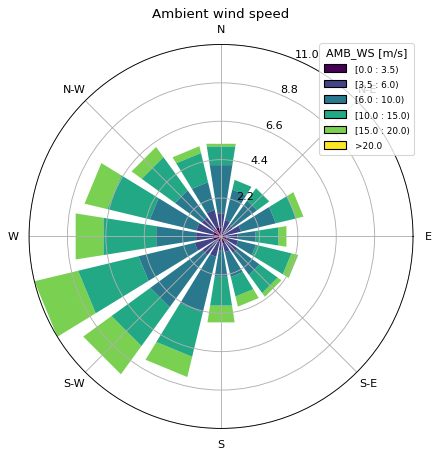

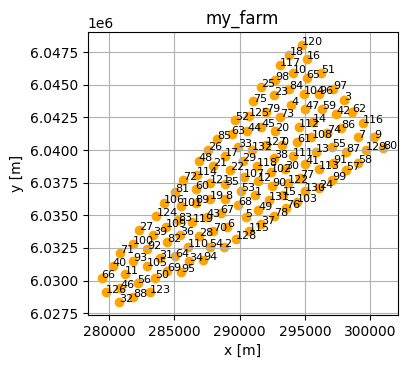

calculating wind farm power for layout-N-9.1.geom.csv for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 109.14 ms
[########################################] | 100% Completed | 144.04 s
Efficiency added to farm results


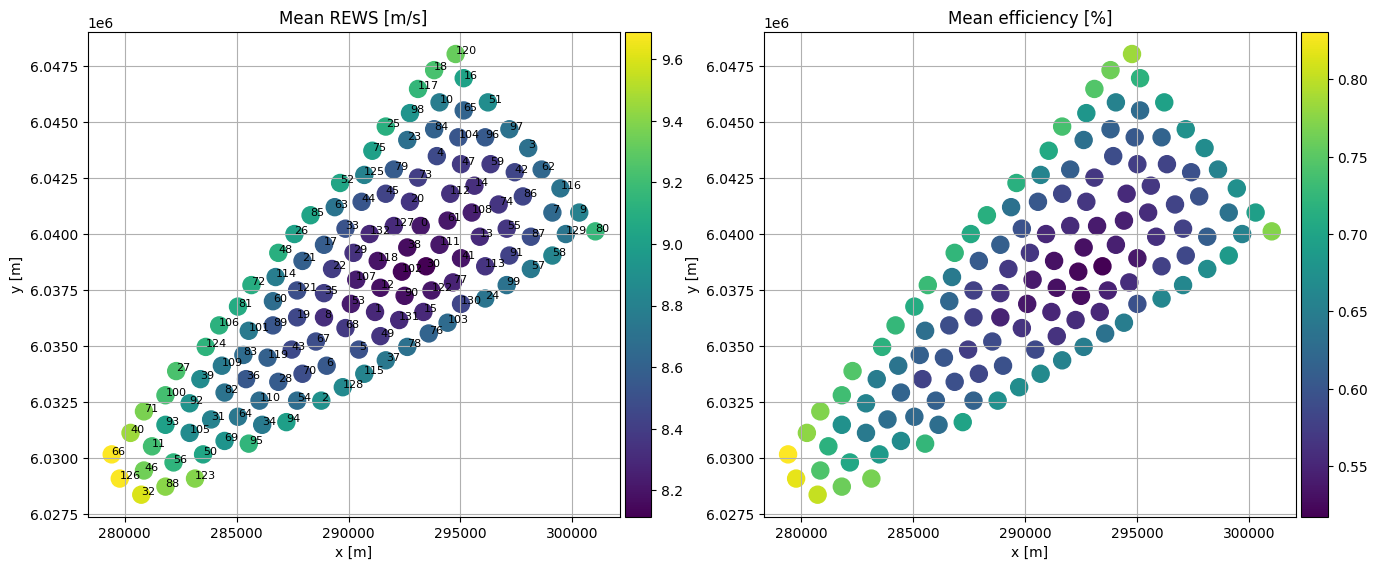


Farm power        : 948.3 MW
Farm ambient power: 1257.6 MW
Farm efficiency   : 75.40 %
Annual farm yield : 8.31 TWh


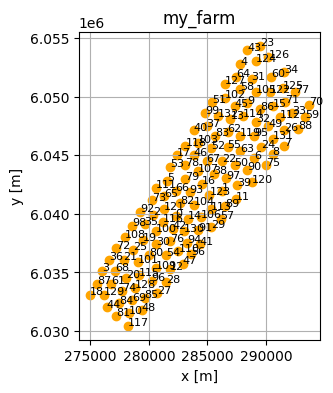

calculating wind farm power for layout-N-9.2.geom.csv for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 106.05 ms
[########################################] | 100% Completed | 138.33 s
Efficiency added to farm results


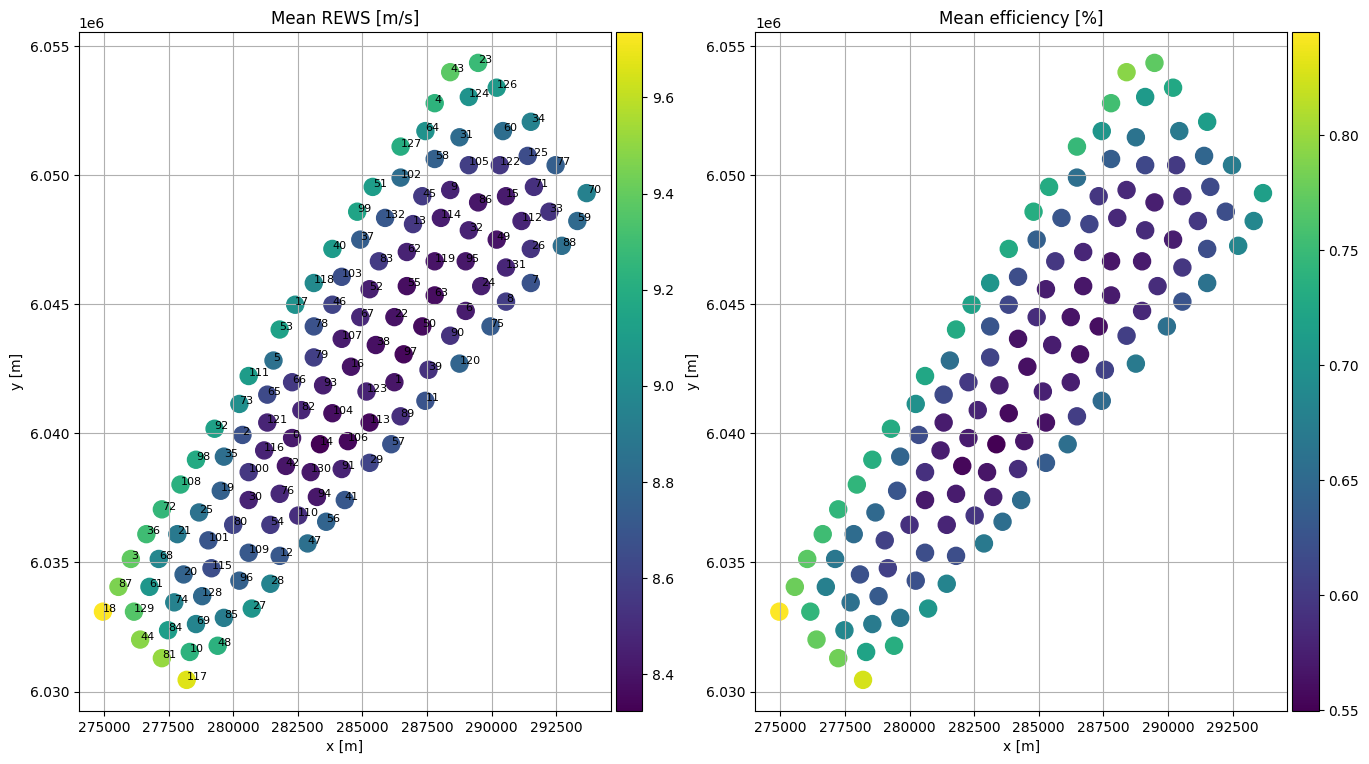


Farm power        : 959.9 MW
Farm ambient power: 1257.6 MW
Farm efficiency   : 76.33 %
Annual farm yield : 8.41 TWh


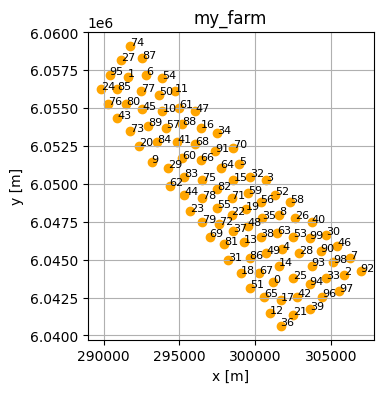

calculating wind farm power for layout-N-9.3.geom.csv for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 111.64 ms
[########################################] | 100% Completed | 88.51 s
Efficiency added to farm results


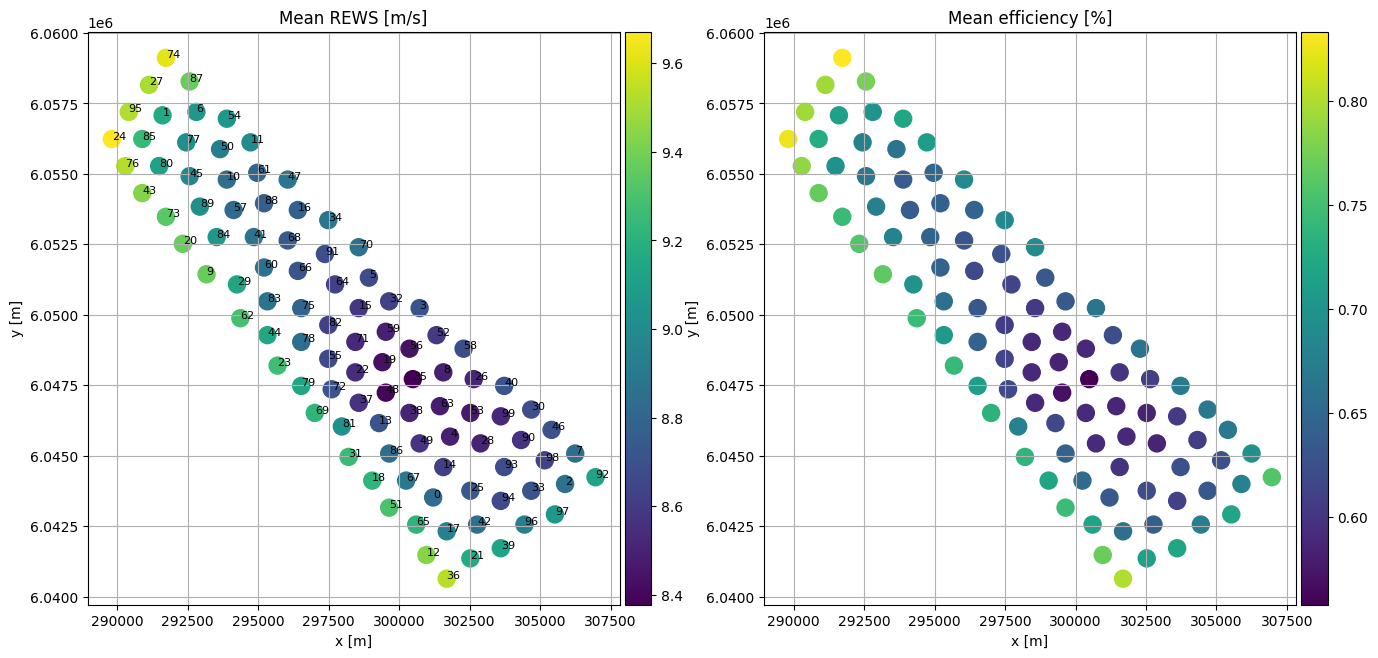


Farm power        : 739.8 MW
Farm ambient power: 945.6 MW
Farm efficiency   : 78.24 %
Annual farm yield : 6.48 TWh


In [5]:
## Running Power calculation for each Area in a function

# import the custome function
from Foxes_Farm_Power import Foxes_Farm_Power
# Foxes_Farm_Power(Farm_Layout+Name,States,Parameters)
    # Farm_Layout+Name  : list containing Layout as df and a string as the name  
        # Farm_Layout : pd.datafram containing Layout of Turbines
        # Name        : Name of the Layout
    # States : Wind conditions
    # Parameters: dict
        # TType         : Turbine-Type           # "NREL5MW" , "IEA15MW"
        # rotor_model   :
        # wake_models   :
        # partial_wakes :

###-------------------------------------add Turbine Layouts----------------------------------###
# create 3 Dataframes for Turbine Layouts
current_path =  turbines_area_of_interest_path                           # path .csv's
turb_files = os.listdir(turbines_area_of_interest_path)
Turb_dfs = [(read_csv(current_path + file),file) for file in turb_files] # read files in path to dataframe and put's those in list, also pass filename


###----------------------------------------Add States-----------------------------------------###
# define States as Foxes object and have a look at the wind rose.
# Wind and other atmospheric inflow conditions are called `States`
States = foxes.input.states.Timeseries(                      # StatesTable for panda df or pd readable file (single height)
    data_source = data_2023 ,                                         # the data
    output_vars = [FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col =     {FV.WS: "long-term_WS150", FV.WD: "long-term_WD150", FV.TI: "time"}, # Mapping from variable names to data column names
    fixed_vars =  {FV.RHO: 1.225, FV.TI: 0.05},                  # TI = Turbulanze Intensity %5 default
    )

# Plot windrose
o = foxes.output.StatesRosePlotOutput(States, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

###--------------------------------------Important Parameters---------------------------------------###
Parameters = dict(                              # passed to the foxes.algorithms.Downwind()
    TType         = "IEA15MW",                  #"NREL5MW","IEA15MW"
    rotor_model   = "centre",
    wake_models   = ["Bastankhah2014_linear"],
    partial_wakes = None,
    )

###--------------------------------------compute farm results--------------------------------------###
Farm_Results = []
for Farm in Turb_dfs:
    Farm_Results.append(Foxes_Farm_Power(Farm,States,Parameters))

# algo.all_models(with_states=True) ##return all models used in our algo    

In [6]:
####-----------------------------------------Results-------------------------------------------#####
# Note: Farm_Results is a list of dataframes

# combine df to single df
Result = Farm_Results[0]
for i in range(len(Farm_Results))[1:]:
    Result.loc[Farm_Results[i].index[0]] = Farm_Results[i].values.flatten().tolist()

# calculate Sum for Power and Mean for Efficiency
Result.loc["Sum / Mean"] = [
    Result[Result.columns[0]].sum(),
    Result[Result.columns[1]].sum(),
    Result[Result.columns[2]].mean(),
    Result[Result.columns[3]].sum()
    ]

Result.head().style.format(precision=1)   # print Result roundet to 1 decimal point

,Farm power [MW],Farm ambient power [MW],Farm efficiency [%],Annual farm yield [TWh]
N-9.1.,948.3,1257.6,75.4,8.3
N-9.2.,959.9,1257.6,76.3,8.4
N-9.3.,739.8,945.6,78.2,6.5
Sum / Mean,2648.0,3460.8,76.7,23.2


### Compute for Farm as a whole

In [10]:
###-------------------------------------get Turbine Layouts----------------------------------###
# combine previus Turbine_Layouts #Julia: here we use the best calc layout considering wake effects? 
Cluster_Turb_df = pd.concat([Turb_dfs[0][0], Turb_dfs[1][0],Turb_dfs[2][0]], ignore_index=True) 
Cluster_Turb_df = (Cluster_Turb_df, "N.9.1-3 Cluster")
# ###--------------------------------------Important Parameters---------------------------------------###
# Parameters = dict(                              # passed to the foxes.algorithms.Downwind()
#     TType         = "IEA15MW",                  #"NREL5MW","IEA15MW"
#     rotor_model   = "centre",
#     wake_models   = ["Bastankhah2014_linear"],
#     partial_wakes = None,
#     )
# ###--------------------------------------compute farm results--------------------------------------###

# Result = pd.concat(                                             # add's new output df to Results Dataframe
#     [Result,                                                    # the previous results we add to 
#     Foxes_Farm_Power(Cluster_Turb_df,States,Parameters)         # run the function
#     ], ignore_index=False)                                      # keep the name we passed
# Result.style.format(precision=1)
 
# # algo.all_models(with_states=True) ##return all models used in our algo    
Cluster_Turb_df[0][['x', 'y']]  

,x,y
0,293224.824041,6.040366e+06
1,291184.824041,6.036526e+06
2,288784.824041,6.032566e+06
3,298024.824041,6.043846e+06
4,293944.824041,6.043486e+06
...,...,...
361,290405.481978,6.057200e+06
362,304445.481978,6.042560e+06
363,305525.481978,6.042920e+06
364,305165.481978,6.044840e+06


## Compute Power for gem.Layout

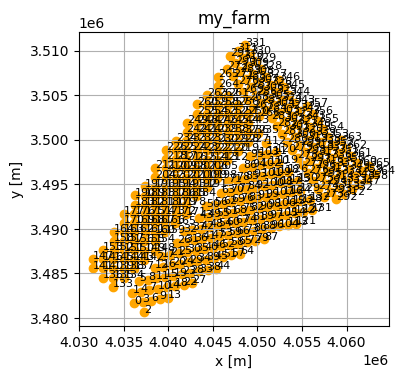

calculating wind farm power for gem.Layout N9 Cluster for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 128.14 ms
[########################################] | 100% Completed | 40m 42s
Efficiency added to farm results


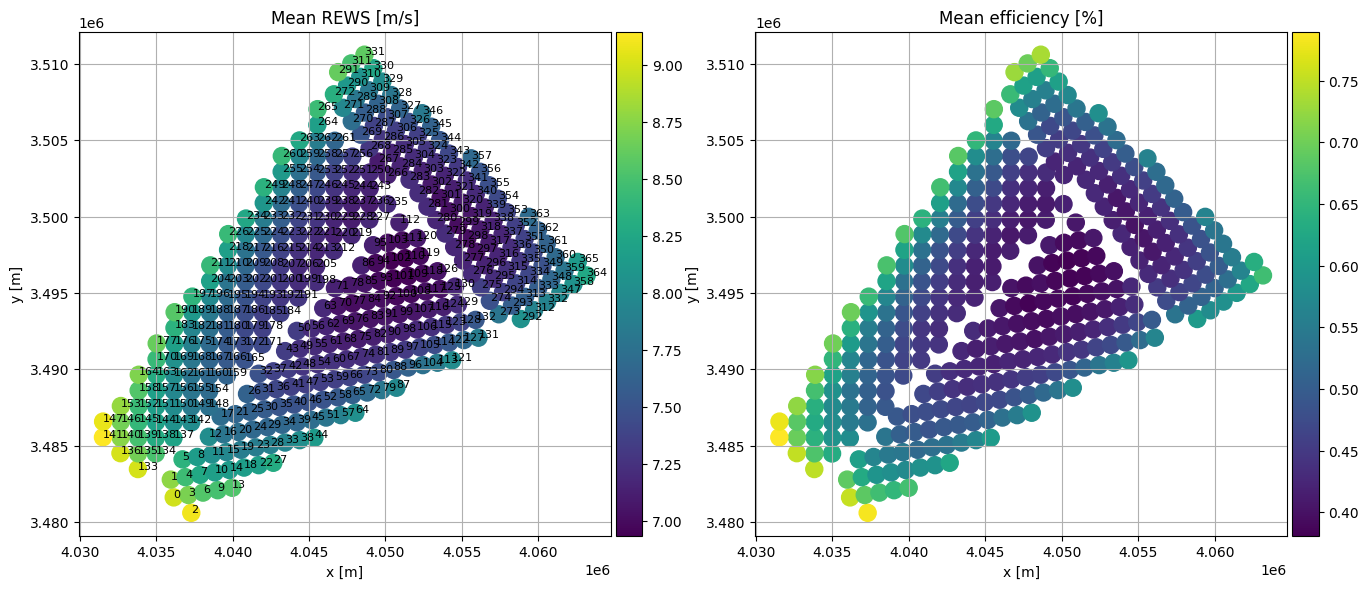


Farm power        : 2146.9 MW
Farm ambient power: 3382.2 MW
Farm efficiency   : 63.48 %
Annual farm yield : 18.81 TWh


,Farm power [MW],Farm ambient power [MW],Farm efficiency [%],Annual farm yield [TWh]
N-9.1.,927.2,1229.1,75.4,8.1
N-9.2.,937.3,1229.1,76.3,8.2
N-9.3.,711.9,924.1,77.0,6.2
Sum / Mean,2576.4,3382.2,76.2,22.6
N.9.1-3 Cluster,2178.7,3382.2,64.4,19.1
gem.Layout N9 Cluster,2146.9,3382.2,63.5,18.8


In [ ]:

###-------------------------------------get Turbine Layouts----------------------------------###
# get the layout we generated in Task 5 by loading the .csv files
Areas = ['N-9.1','N-9.2','N-9.3'] 
Layout_Path = ["NoWake_Layout_" + area + ".csv" for area in Areas]
Layout_dfs = [read_csv(file) for file in Layout_Path]                #list of dataframes

geo_Cluster_Turb_df = pd.concat([Layout_dfs[0],Layout_dfs[1],Layout_dfs[2]], ignore_index=True)
geo_Cluster_Turb_df = [geo_Cluster_Turb_df, "gem.Layout N9 Cluster"]   # with name to pass to Funktion
###--------------------------------------Important Parameters---------------------------------------###
Parameters = dict(                              # passed to the foxes.algorithms.Downwind()
    TType         = "IEA15MW",                  #"NREL5MW","IEA15MW"
    rotor_model   = "centre",
    wake_models   = ["Bastankhah2014_linear"],
    partial_wakes = None,
    )
###--------------------------------------compute farm results--------------------------------------###

Result = pd.concat(                                             # add's new output df to Results Dataframe
    [Result,                                                    # the previous results we add to 
    Foxes_Farm_Power(geo_Cluster_Turb_df,States,Parameters)         # run the function
    ], ignore_index=False)                                      # keep the name we passed
Result.style.format(precision=1) 

### Task 7: Use different Foxes Setup


In [ ]:
# # chose diffrent Parameters. Here is a list of all options.
# mbook_show = foxes.ModelBook()
# mbook_show.print_toc()     # print all available Models

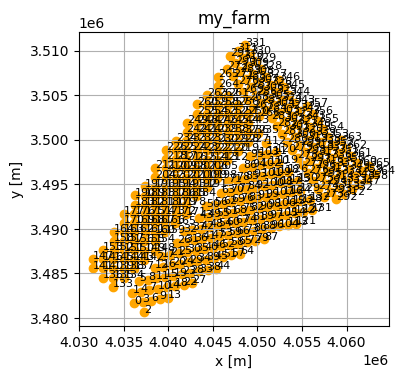

calculating wind farm power for gem.Layout N9 Cluster(TurbOPark) for Wake Model: ['TurbOPark_linear']:
[########################################] | 100% Completed | 1.32 s
[########################################] | 100% Completed | 45m 22s
Efficiency added to farm results


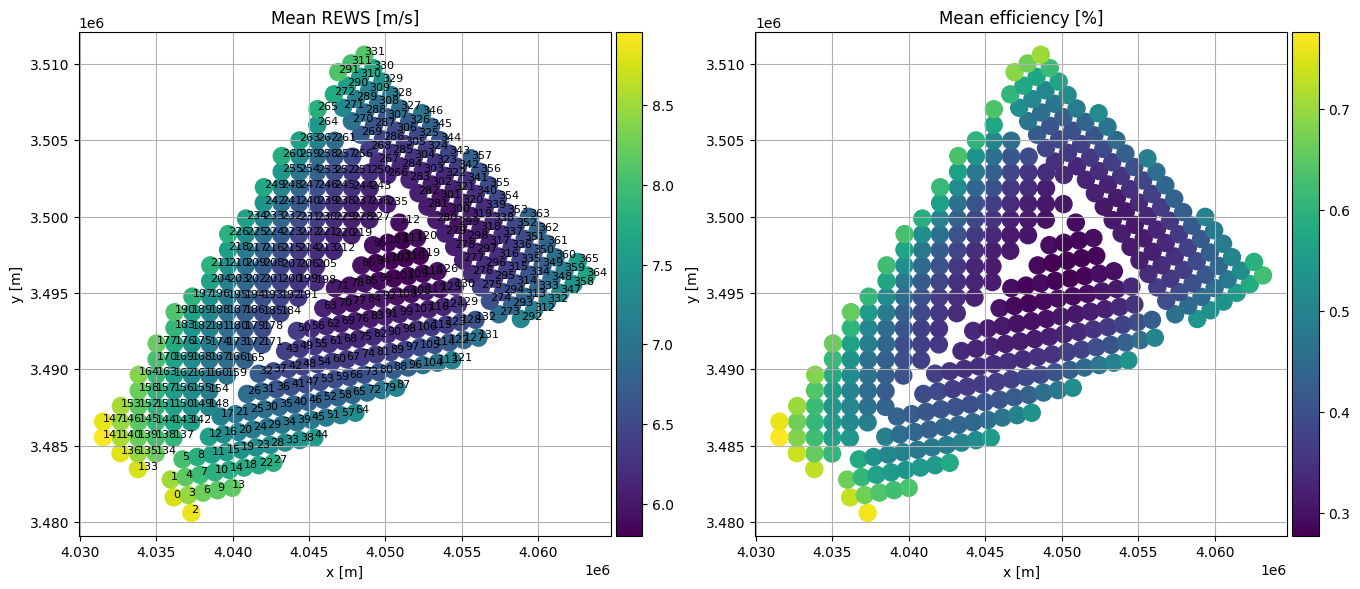


Farm power        : 1876.9 MW
Farm ambient power: 3382.2 MW
Farm efficiency   : 55.49 %
Annual farm yield : 16.44 TWh


,Farm power [MW],Farm ambient power [MW],Farm efficiency [%],Annual farm yield [TWh]
N-9.1.,927.2,1229.1,75.4,8.1
N-9.2.,937.3,1229.1,76.3,8.2
N-9.3.,711.9,924.1,77.0,6.2
Sum / Mean,2576.4,3382.2,76.2,22.6
N.9.1-3 Cluster,2178.7,3382.2,64.4,19.1
gem.Layout N9 Cluster,2146.9,3382.2,63.5,18.8
gem.Layout N9 Cluster(TurbOPark),1876.9,3382.2,55.5,16.4


In [ ]:
## TurbOPark Modell

## rest is same as above 

geo_Cluster_Turb_df[1] = "gem.Layout N9 Cluster(TurbOPark)"    # change Name 
###--------------------------------------Important Parameters---------------------------------------###
Parameters = dict(                              
    TType         = "IEA15MW",                  
    rotor_model   = "centre",
    wake_models   = ["TurbOPark_linear"],            #changed from: ["Bastankhah2014_linear"]
    partial_wakes = None,
    )
###--------------------------------------compute farm results--------------------------------------###
Result = pd.concat(                                             # add's new output df to Results Dataframe
    [Result,                                                    # the previous results we add to 
    Foxes_Farm_Power(geo_Cluster_Turb_df,States,Parameters)         # run the function
    ], ignore_index=False)                                      # keep the name we passed
Result.style.format(precision=1)

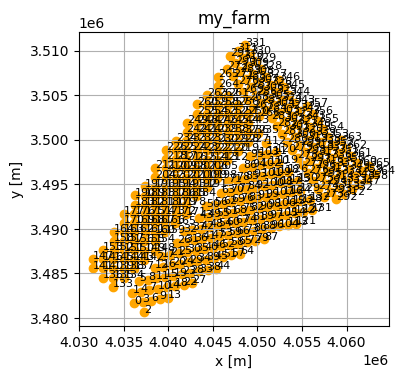

calculating wind farm power for gem.Layout N9 Cluster(Jensen) for Wake Model: ['Jensen_linear']:
[########################################] | 100% Completed | 121.89 ms
[########################################] | 100% Completed | 334.96 s
Efficiency added to farm results


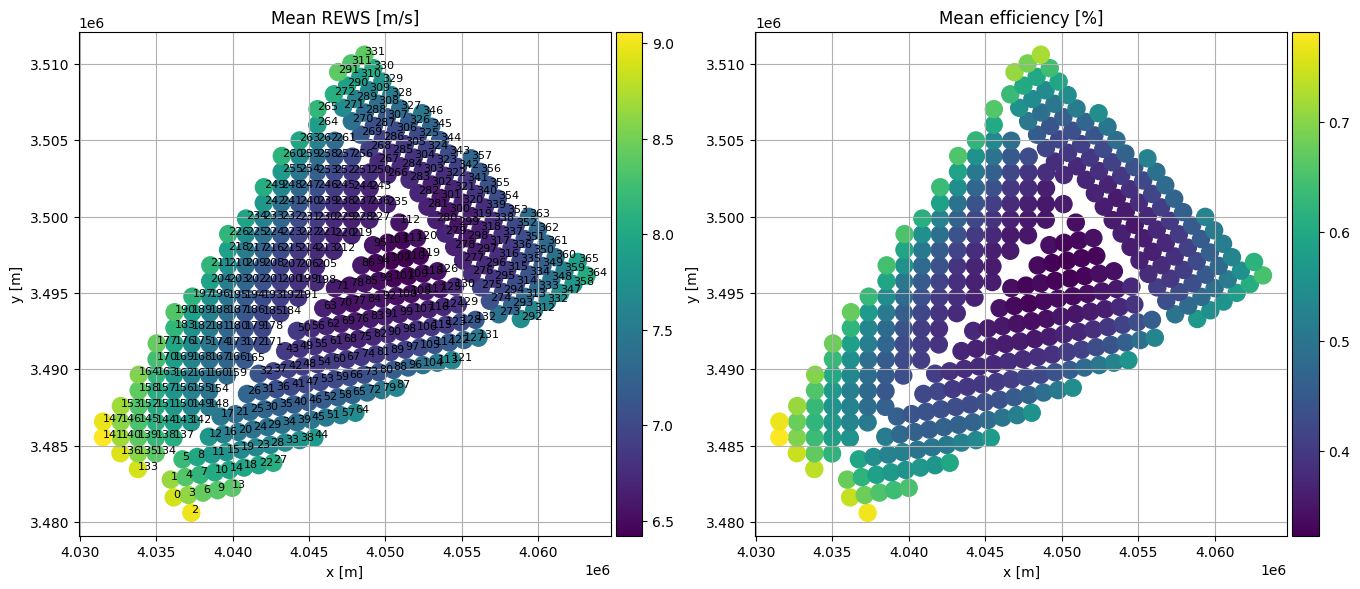


Farm power        : 2027.7 MW
Farm ambient power: 3382.2 MW
Farm efficiency   : 59.95 %
Annual farm yield : 17.76 TWh


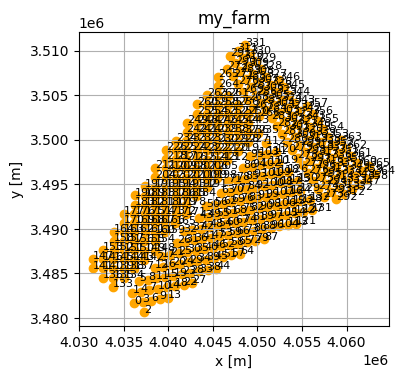

calculating wind farm power for gem.Layout N9 Cluster(Jensen) for Wake Model: ['Jensen_linear']:
[########################################] | 100% Completed | 119.77 ms
[########################################] | 100% Completed | 348.41 s
Efficiency added to farm results


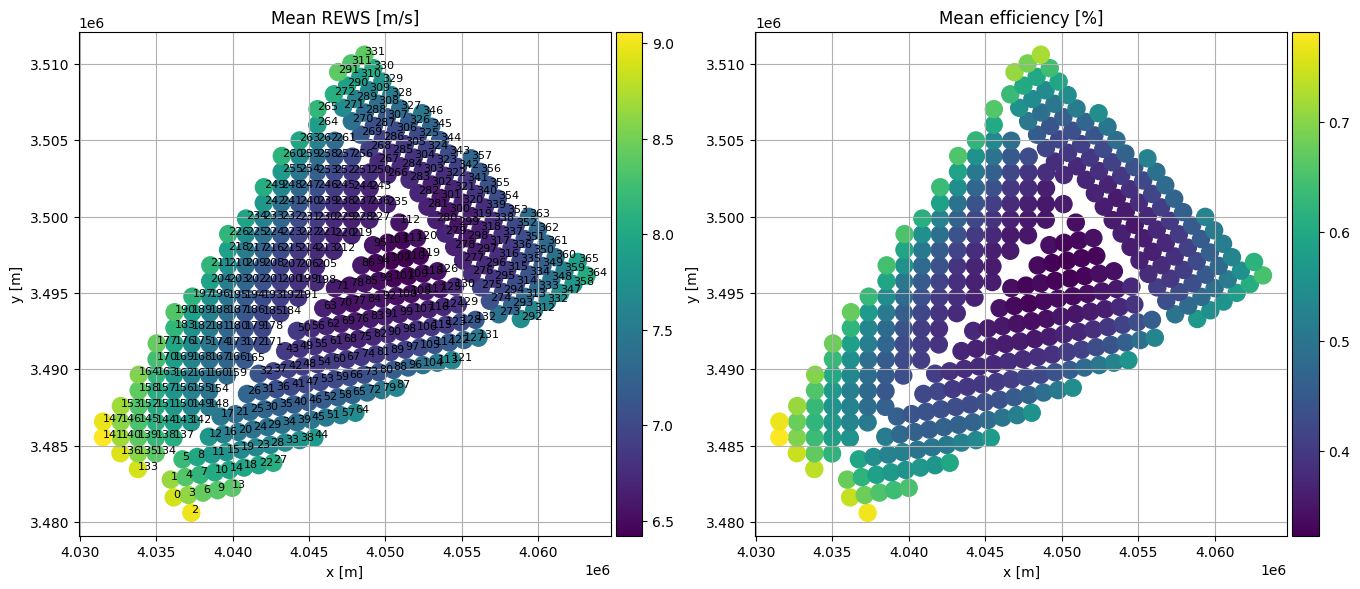


Farm power        : 2027.7 MW
Farm ambient power: 3382.2 MW
Farm efficiency   : 59.95 %
Annual farm yield : 17.76 TWh


,Farm power [MW],Farm ambient power [MW],Farm efficiency [%],Annual farm yield [TWh]
N-9.1.,927.2,1229.1,75.4,8.1
N-9.2.,937.3,1229.1,76.3,8.2
N-9.3.,711.9,924.1,77.0,6.2
Sum / Mean,2576.4,3382.2,76.2,22.6
N.9.1-3 Cluster,2178.7,3382.2,64.4,19.1
gem.Layout N9 Cluster,2146.9,3382.2,63.5,18.8
gem.Layout N9 Cluster(TurbOPark),1876.9,3382.2,55.5,16.4
gem.Layout N9 Cluster(Jensen),2027.7,3382.2,60.0,17.8


In [ ]:
## Jensen Modell

## rest is same as above 

geo_Cluster_Turb_df[1] = "gem.Layout N9 Cluster(Jensen)"    # change Name 
###--------------------------------------Important Parameters---------------------------------------###
Parameters = dict(                              
    TType         = "IEA15MW",                  
    rotor_model   = "centre",
    wake_models   = ["Jensen_linear"],            #changed from: ["Bastankhah2014_linear"]
    partial_wakes = None,
    )
###--------------------------------------compute farm results--------------------------------------###
Jensen = Foxes_Farm_Power(geo_Cluster_Turb_df,States,Parameters)

Result = pd.concat(                                             # add's new output df to Results Dataframe
    [Result,                                                    # the previous results we add to 
    Foxes_Farm_Power(geo_Cluster_Turb_df,States,Parameters)         # run the function
    ], ignore_index=False)                                      # keep the name we passed
Result.style.format(precision=1)